In [1]:
import operators
from data_management import IPDataset
import config
import torch
import matplotlib.pyplot as plt
import numpy as np


### Device setup

In [2]:
device = torch.device("cuda")

### Dataset setup

In [3]:
test_data = IPDataset("test", config.DATA_PATH)
samples = range(48, 48 + 1)
X_0 = torch.stack([test_data[s][0] for s in samples])
X_0.shape

torch.Size([1, 1, 256, 256])

### Plot single image from dataset

Text(0.5, 1.0, 'Example input image')

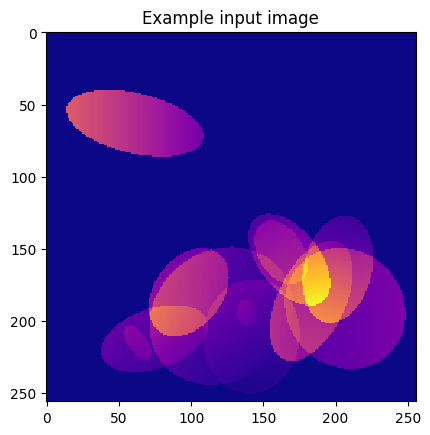

In [4]:
plt.imshow(X_0[0, :, :].squeeze(0), cmap="plasma")
plt.title("Example input image")

### Initialize wavelet operator

In [5]:
level = 2
input_shape = [256, 256]
W = operators.Wavelet(input_shape, device, level)
print("shape of input array: ", W.get_in_shape())
print("shape of output array: ", W.get_out_shape())

shape of input array:  [256, 256]
shape of output array:  (256, 256)


### Test single image and batch processing

In [6]:
y_single = W.dot(X_0[0, :, :])
y_batch = W.dot(X_0)
print("single output vector shape:", y_single.shape)
print("output vector batch shape:", y_batch.shape)


single output vector shape: torch.Size([1, 65536])
output vector batch shape: torch.Size([1, 1, 65536])


In [7]:
y_single_image = operators.vec2im(y_single, W.get_out_shape())
y_batch_image = operators.vec2im(y_batch, W.get_out_shape())
print("single output image shape:", y_single_image.shape)
print("output image batch shape:", y_batch_image.shape)


single output image shape: torch.Size([1, 256, 256])
output image batch shape: torch.Size([1, 1, 256, 256])


In [8]:
y_single_image_numpy = y_single_image.cpu().detach().numpy()
y_batch_image_numpy = y_batch_image.cpu().detach().numpy()
y_single_image_numpy = np.squeeze(y_single_image_numpy, axis=0)
y_batch_image_numpy = np.squeeze(y_batch_image_numpy, axis=1)


### Plot of sample input image after forward operator applied

/tmp/ipykernel_10063/2053690027.py:3: RuntimeWarning: divide by zero encountered in log10
  np.log10(y_single_image_numpy), interpolation="nearest", cmap="plasma"
/tmp/ipykernel_10063/2053690027.py:3: RuntimeWarning: invalid value encountered in log10
  np.log10(y_single_image_numpy), interpolation="nearest", cmap="plasma"
/tmp/ipykernel_10063/2053690027.py:8: RuntimeWarning: divide by zero encountered in log10
  np.log10(y_batch_image_numpy[0, :, :]),
/tmp/ipykernel_10063/2053690027.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(y_batch_image_numpy[0, :, :]),


Text(0.5, 1.0, 'example from batch \n of images processing result')

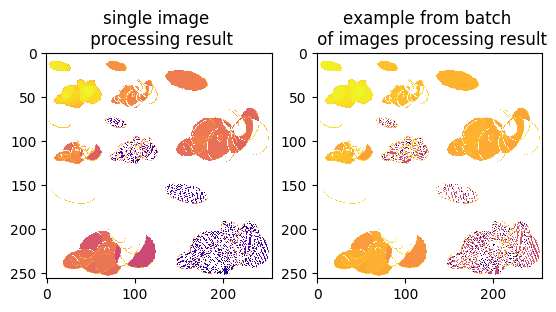

In [9]:
plt.subplot(1,2,1)
plt.imshow(
    np.log10(y_single_image_numpy), interpolation="nearest", cmap="plasma"
)
plt.title("single image \n processing result")
plt.subplot(1,2,2)
plt.imshow(
    np.log10(y_batch_image_numpy[0, :, :]),
    interpolation="nearest",
    cmap="plasma",
)
plt.title("example from batch \n of images processing result")

### Compute adjoint images

In [10]:
b_batch = W.adj(y_batch)
b_single = W.adj(y_single)
print("computed inverse batch shape:", b_batch.shape)
print("computed inverse single image shape", b_single.shape)


computed inverse batch shape: torch.Size([1, 256, 256])
computed inverse single image shape torch.Size([256, 256])


### Plot of adjoint images

Text(0.5, 1.0, 'example from batch \n adjoint processing result')

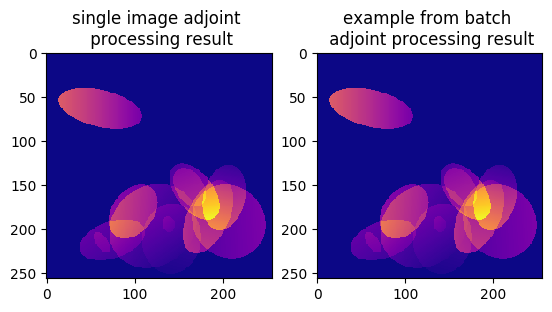

In [11]:
plt.subplot(1,2,1)
b_single_plot = b_batch[0, :, :].cpu().detach().numpy()
plt.imshow(b_single_plot, cmap="plasma")
plt.title("single image adjoint \n processing result")
plt.subplot(1,2,2)
b_batch_plot = b_batch.cpu().detach().numpy()[0, :, :]
plt.imshow(b_batch_plot, cmap="plasma")
plt.title("example from batch \n adjoint processing result")

### Plot of all stages of processing

/tmp/ipykernel_10063/1182914595.py:7: RuntimeWarning: divide by zero encountered in log10
  np.log10(y_single_image_numpy), interpolation="nearest", cmap="plasma"
/tmp/ipykernel_10063/1182914595.py:7: RuntimeWarning: invalid value encountered in log10
  np.log10(y_single_image_numpy), interpolation="nearest", cmap="plasma"


Text(0.5, 1.0, 'Adjoint of Transform of Input')

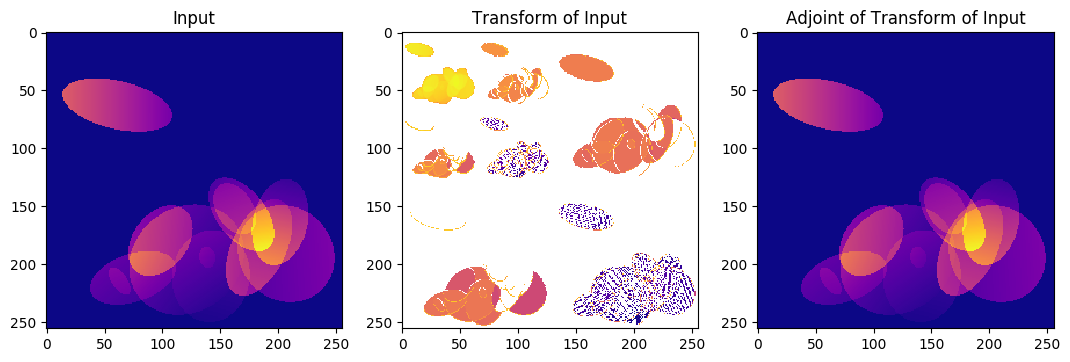

In [12]:
plt.figure(figsize=(13, 11))
plt.subplot(1,3,1)
plt.imshow(X_0[0, :, :].squeeze(0), cmap="plasma")
plt.title("Input")
plt.subplot(1,3,2)
plt.imshow(
    np.log10(y_single_image_numpy), interpolation="nearest", cmap="plasma"
)
plt.title("Transform of Input")
plt.subplot(1,3,3)
plt.imshow(b_single_plot, cmap="plasma")
plt.title("Adjoint of Transform of Input")

### Test reconstruction method using wavelet operator

In [13]:
import reconstruction_methods

In [14]:
mask_func = operators.RadialMaskFunc(config.n, 40)
mask = operators.unprep_fft_channel(mask_func((1, 1) + config.n + (1,)))
OpA = operators.Fourier(mask)
OpW = W


In [71]:
def wavelet_reconstruction(y, lam, rho):
    x, _ = reconstruction_methods.admm_l1_rec(
        y,
        OpA,
        OpW,
        OpA.adj(y),
        OpW(OpA.adj(y)),
        lam,
        rho,
        iter=1,
        silent=False,
    )
    return x


In [72]:
X_0 = operators.to_complex(X_0.to(device))
X_0.shape


torch.Size([1, 2, 256, 256])

In [73]:
noise_min = 5e-3
noise_max = 3e-2
noise_steps = 10
noise_rel = torch.tensor(
    np.logspace(np.log10(noise_min), np.log10(noise_max), num=noise_steps)
).float()
noise_rel = torch.cat([torch.zeros(1).float(), noise_rel]).float().to(device)

noise_level = noise_rel[0] * OpA(X_0).norm(
            p=2, dim=(-2, -1), keepdim=True
        )

### Measurent vectors $y = P_{\Omega} \circ \mathcal{F} x + \varepsilon$

In [74]:
Y_ref = operators.noise_gaussian(OpA.dot(X_0), noise_level)
Y_ref.shape

torch.Size([1, 2, 10941])

### naive reconstruction using only $A^{\dagger} = (P_{\Omega} \circ \mathcal{F})^{\dagger}$

In [75]:
x_naive = OpA.adj(Y_ref)
x_naive.shape

torch.Size([1, 2, 256, 256])

In [76]:
#parameters obtained from grid search :)
lam = 0.01
rho = 0.774263682681127

In [77]:
x_rec = wavelet_reconstruction(Y_ref, lam, rho)


ADMM iterations: 100%|██████████| 1/1 [00:00<00:00,  6.02it/s, dres=1.76, loss=24.8, pres=2.28]


### Plot of naive reconstruction vs. plot of CS reconstruction

Text(0.5, 1.0, 'Compressed Sensing, \n Wavelet Regularized Reconstruction')

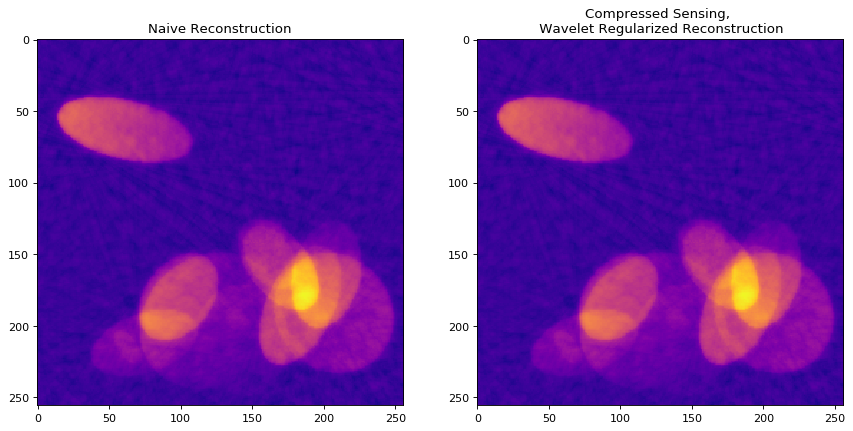

In [78]:
plt.figure(figsize=(13, 11), dpi=80)
plt.subplot(1, 2, 1)
plt.imshow(x_naive[0, 0, :, :].detach().cpu().numpy(), cmap="plasma")
plt.title("Naive Reconstruction")
plt.subplot(1, 2, 2)
plt.imshow(x_rec[0, 0, :, :].detach().cpu().numpy(), cmap="plasma")
plt.title("Compressed Sensing, \n Wavelet Regularized Reconstruction")


### Dealing with high order tensors

In [79]:
test_measurement_tensor = torch.zeros(3, 3, 5, 2, 10941).to(device)
test_measurement_tensor.shape

torch.Size([3, 3, 5, 2, 10941])

In [85]:
n_locs = (3,3)
list1 = test_measurement_tensor.unbind(0)
out1 = []
for i in range(n_locs[0]):
    list2 = list1[i].unbind(0)
    out2 = []
    for j in range(n_locs[1]):
        temp = wavelet_reconstruction(list2[j], lam, rho)
        out2.append(temp)
    out1.append(torch.stack(out2, dim=0))
out_tensor = torch.stack(out1, dim=0)

ADMM iterations: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s, dres=0, loss=0, pres=0]


In [86]:
out_tensor.shape

torch.Size([3, 3, 5, 2, 256, 256])

In [ ]:
test_reconstruction_tensor = wavelet_reconstruction(test_measurement_tensor, lam, rho)

ADMM iterations:   0%|          | 0/100 [00:00<?, ?it/s]


ValueError: All detail shapes must be the same length.